# Training RBM and RTRBM on RTRBM generated data

100%|██████████| 500/500 [01:43<00:00,  4.84it/s]


training RBM...


100%|██████████| 5000/5000 [1:23:31<00:00,  1.00s/it]


training RTRBM...


100%|██████████| 30/30 [00:00<00:00, 1424.94it/s]


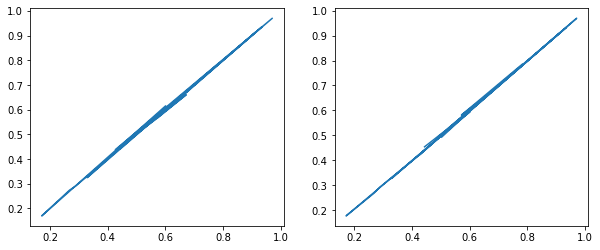

In [1]:
import numpy as np
import torch
from tqdm import tqdm
from boltzmann_machines.cp_rtrbm import RTRBM


def get_rtrbm_data(N_H=3, N_V=21, T=30, n_batches=1, pre_gibbs_k=100, gibbs_k=100, mode=1):

    # Generate W matrix
    W = torch.randn(N_H, N_V)
    U = torch.randn(N_H, N_H)

    # Initialize RTRBM and data in batches
    data = torch.zeros(N_V, T)
    rtrbm = RTRBM(data, N_H=N_H, device='cpu')

    data = torch.zeros(N_V, T, n_batches, dtype=torch.float)
    rt = torch.zeros(N_H, T, n_batches)
    rtrbm.W = W
    rtrbm.U = U

    # sample data from RTRBM
    for batch in tqdm(range(n_batches)):
        v_start = (torch.rand(N_V) > 0.2) * 1.0
        data[..., batch], rt[..., batch] = rtrbm.sample(
            v_start.type(torch.float).T,
            chain=T,
            pre_gibbs_k=pre_gibbs_k,
            gibbs_k=gibbs_k,
            mode=mode,
            disable_tqdm=True
        )

    return rtrbm, data, rt

import matplotlib.pyplot as plt
import seaborn as sns
from utils.rbm_vs_rtrbm import train_rbm_rtrbm

N_H, N_V, T, n_batches = 3, 21, 30, 500

generated, data, rt = get_rtrbm_data(n_batches=n_batches)

rbm, rtrbm = train_rbm_rtrbm(
    data,
    N_H=3,
    device='cpu',
    n_epochs=5000,
    lr=1e-4,
    return_machines=True,
    batch_size=10
)

vs_rtrbm = torch.empty(N_V, T, n_batches)
hs_rtrbm = torch.empty(N_H, T, n_batches)
vs_rbm = torch.empty(N_V, T, n_batches)
hs_rbm = torch.empty(N_H, T, n_batches)

for batch in range(n_batches):
    vs_rtrbm[:, :, batch], hs_rtrbm[:, :, batch] = rtrbm.infer(data[:, :T//2, batch])
    vs_rbm[:, :, batch], hs_rbm[:, :, batch] = rbm.sample(data[:, 0, batch], chain=T)

_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1].plot(torch.mean(data, (1, 2)), torch.mean(vs_rtrbm[:, T//2:, :], (1, 2)))
ax[0].plot(torch.mean(data, (1, 2)), torch.mean(vs_rbm[:, T//2:, :], (1, 2)))

plt.show()

In [25]:
def get_param_history_rbm(parameter_history):
    """
    Returns parameter history per parameter as torch tensor
    """
    epochs = len(parameter_history)
    N_H, N_V = np.shape(parameter_history[0][0])
    W = torch.empty(epochs, N_H, N_V)
    b_V = torch.empty(epochs, 1, N_V)
    b_H = torch.empty(epochs, 1, N_H)

    for ep, params in enumerate(parameter_history):
        W[ep] = params[0].clone().detach()
        b_H[ep] = params[1].clone().detach()
        b_V[ep] = params[2].clone().detach()

    return W, b_H, b_V

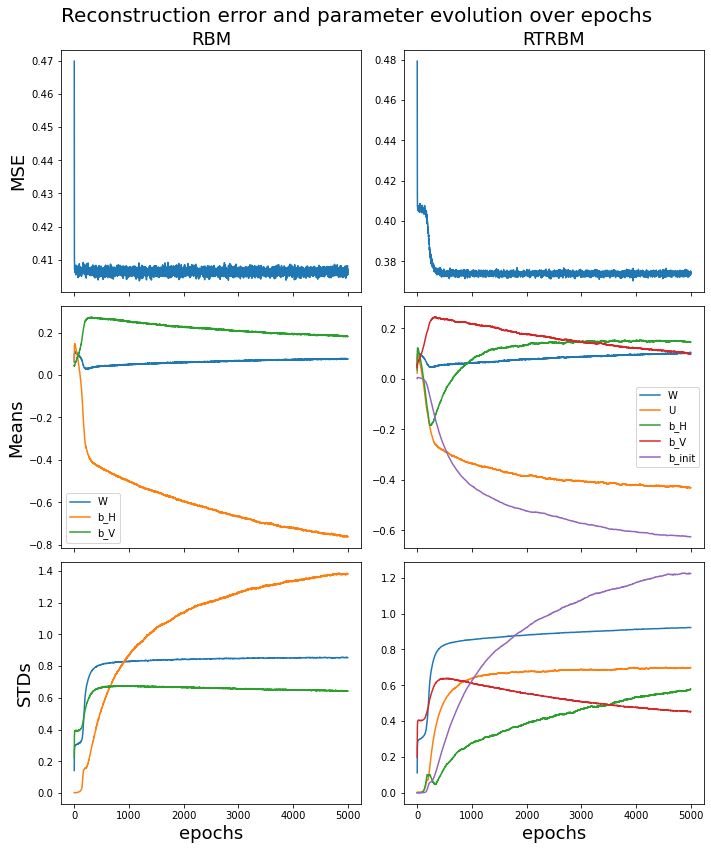

In [29]:
from utils.funcs import get_param_history
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True)
axes[0, 0].plot(rbm.errors)
axes[0, 1].plot(rtrbm.errors)
axes[0, 0].set_title('RBM', fontsize=18)
axes[0, 1].set_title('RTRBM', fontsize=18)
axes[2, 0].set_xlabel('epochs', fontsize=18)
axes[2, 1].set_xlabel('epochs', fontsize=18)
axes[0, 0].set_ylabel('MSE', fontsize=18)
W, U, b_H, b_V, b_init = get_param_history(rtrbm.parameter_history)
epochs = np.arange(W.shape[0])
params = [W, U, b_H, b_V, b_init]
for param in params:
    axes[1, 1].plot(epochs, torch.mean(param, (1, 2)))
    axes[2, 1].plot(epochs, torch.std(param, (1, 2)))
W, b_H, b_V = get_param_history_rbm(rbm.parameter_history)
epochs = np.arange(W.shape[0])
params = [W, b_H, b_V]
for param in params:
    axes[1, 0].plot(epochs, torch.mean(param, (1, 2)))
    axes[2, 0].plot(epochs, torch.std(param, (1, 2)))

axes[1, 0].legend(['W', 'b_H', 'b_V'])
axes[1, 1].legend(['W', 'U', 'b_H', 'b_V', 'b_init'])
axes[1, 0].set_ylabel('Means', fontsize=18)
axes[2, 0].set_ylabel('STDs', fontsize=18)

plt.suptitle('Reconstruction error and parameter evolution over epochs', fontsize=20)
plt.tight_layout()
plt.show()

### Plotting the weights and their correlations

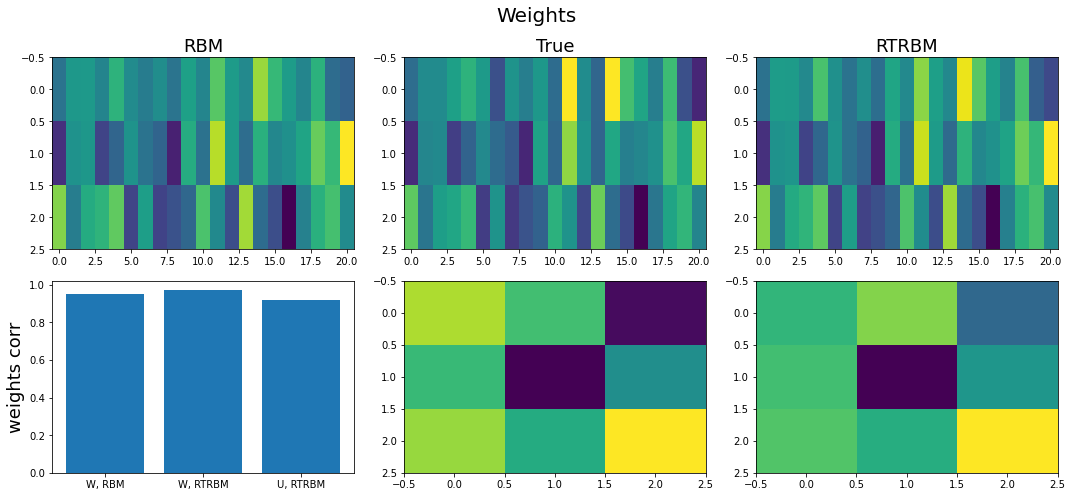

In [41]:
U = rtrbm.U[(1, 2, 0), :]
U = U[:, (1, 2, 0)]

fig, axes = plt.subplots(2, 3, figsize=(15, 7))

axes[0, 0].imshow(rbm.W[(2, 1, 0), :], aspect='auto')
axes[0, 1].imshow(generated.W, aspect='auto')
axes[0, 2].imshow(rtrbm.W[(1, 2, 0), :], aspect='auto')
axes[1, 1].imshow(generated.U, aspect='auto')
axes[1, 2].imshow(U, aspect='auto')

axes[0, 0].set_title('RBM', fontsize=18)
axes[0, 1].set_title('True', fontsize=18)
axes[0, 2].set_title('RTRBM', fontsize=18)

corr_rbm_W = np.corrcoef(generated.W.flatten(), rbm.W[(2, 1, 0), :].flatten())[0, 1]
corr_rtrbm_W = np.corrcoef(generated.W.flatten(), rtrbm.W[(1, 2, 0), :].flatten())[0, 1]
corr_rtrbm_U = np.corrcoef(generated.U.flatten(), U.flatten())[0, 1]
axes[1, 0].bar(['W, RBM', 'W, RTRBM', 'U, RTRBM'], [corr_rbm_W, corr_rtrbm_W, corr_rtrbm_U])
axes[1, 0].set_ylabel('weights corr', fontsize=18)

fig.suptitle('Weights', fontsize=20)

plt.tight_layout()
plt.show()

### Sampling data

In [7]:
from data.reshape_data import reshape_from_batches

vt = reshape_from_batches(data)
vs_rbm = reshape_from_batches(vs_rbm[:, T//2:, :])
vs_rtrbm = reshape_from_batches(vs_rtrbm[:, T//2:, :])

vvt = np.array(torch.matmul(vt, vt.T) / vt.shape[1]).flatten()
vvs_rbm = np.array(torch.matmul(vs_rbm, vs_rbm.T) / vs_rbm.shape[1]).flatten()
vvs_rtrbm = np.array(torch.matmul(vs_rtrbm, vs_rtrbm.T) / vs_rtrbm.shape[1]).flatten()

In [80]:
from data.reshape_data import reshape

vt_ = reshape(vt, T=T, n_batches=n_batches)
vs_rbm_ = reshape(vs_rbm, T=T//2, n_batches=n_batches)
vs_rtrbm_ = reshape(vs_rtrbm, T=T//2, n_batches=n_batches)


print(torch.mean((vt_[:, T//2:, :] - vs_rbm_)**2))
print(torch.mean((vt_[:, T//2:, :] - vs_rtrbm_)**2))

tensor(0.4064)
tensor(0.2293)


In [79]:
print(vt_)

None


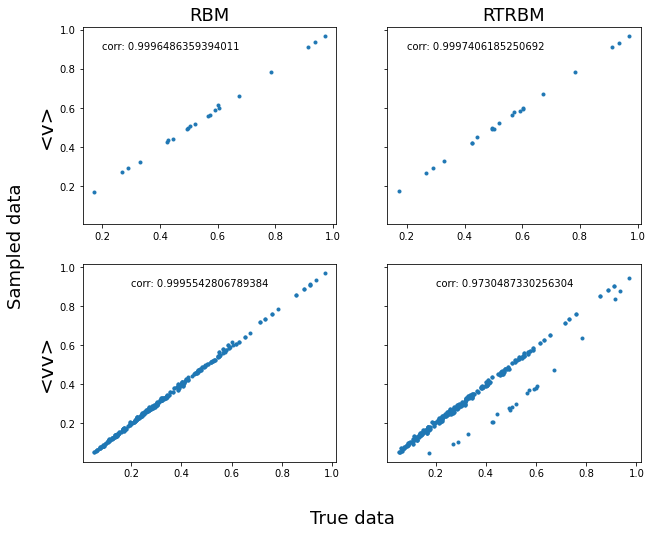

In [28]:
vr_rbm = np.corrcoef(torch.mean(vt, 1), torch.mean(vs_rbm, 1))[0, 1]
vr_rtrbm = np.corrcoef(torch.mean(vt, 1), torch.mean(vs_rtrbm, 1))[0, 1]
vvr_rbm = np.corrcoef(vvt, vvs_rbm)[0, 1]
vvr_rtrbm = np.corrcoef(vvt, vvs_rtrbm)[0, 1]

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

ax[0, 0].plot(torch.mean(vt, 1), torch.mean(vs_rbm, 1), '.')
ax[0, 1].plot(torch.mean(vt, 1), torch.mean(vs_rtrbm, 1), '.')
ax[0, 0].text(.2, .9, 'corr: ' + str(vr_rbm))
ax[0, 1].text(.2, .9, 'corr: ' + str(vr_rtrbm))

ax[1, 0].plot(vvt, vvs_rbm, '.')
ax[1, 1].plot(vvt, vvs_rtrbm, '.')
ax[1, 0].text(.2, .9, 'corr: ' + str(vvr_rbm))
ax[1, 1].text(.2, .9, 'corr: ' + str(vvr_rtrbm))

ax[0, 0].set_title('RBM', fontsize=18)
ax[0, 0].set_ylabel('<v>', fontsize=20)
ax[1, 0].set_ylabel('<vv>', fontsize=20)
ax[0, 1].set_title('RTRBM', fontsize=18)

fig.supylabel('Sampled data', fontsize=18)
fig.supxlabel('True data', fontsize=18)
plt.show()

# Training RBM and RTRBM on RBM generated data

In [42]:
from boltzmann_machines.cp_rbm import RBM

In [73]:
def get_rbm_data(N_H=3, N_V=21, T=30, n_batches=1, pre_gibbs_k=100, gibbs_k=100, mode=1):

    # Generate W matrix
    W = torch.randn(N_H, N_V)

    # Initialize RTRBM and data in batches
    data = torch.zeros(N_V, T)
    rbm = RBM(data, N_H=N_H, device='cpu')

    data = torch.zeros(N_V, T, n_batches, dtype=torch.float)
    rt = torch.zeros(N_H, T, n_batches)
    rbm.W = W

    # sample data from RTRBM
    for batch in tqdm(range(n_batches)):
        v_start = (torch.rand(N_V) > 0.2) * 1.0
        data[..., batch], rt[..., batch] = rbm.sample(
            v_start.type(torch.float).T,
            chain=T,
            pre_gibbs_k=pre_gibbs_k,
            gibbs_k=gibbs_k,
            mode=mode,
            disable_tqdm=True
        )

    return rbm, data, rt

N_H, N_V, T, n_batches = 3, 21, 30, 500

generated1, data1, rt1 = get_rbm_data(n_batches=n_batches)

rbm1, rtrbm1 = train_rbm_rtrbm(
    data1,
    N_H=3,
    device='cpu',
    n_epochs=5000,
    lr=3e-5,
    return_machines=True,
    batch_size=10
)

vs_rtrbm1 = torch.empty(N_V, T, n_batches)
hs_rtrbm1 = torch.empty(N_H, T, n_batches)
vs_rbm1 = torch.empty(N_V, T, n_batches)
hs_rbm1 = torch.empty(N_H, T, n_batches)

for batch in range(n_batches):
    vs_rtrbm1[:, :, batch], hs_rtrbm1[:, :, batch] = rtrbm1.infer(data[:, :T//2, batch], disable_tqdm=True)
    vs_rbm1[:, :, batch], hs_rbm1[:, :, batch] = rbm1.sample(data[:, 0, batch], chain=T, disable_tqdm=True)

100%|██████████| 500/500 [00:54<00:00,  9.12it/s]


training RBM...


 19%|█▉        | 959/5000 [16:24<1:09:08,  1.03s/it]


KeyboardInterrupt: 

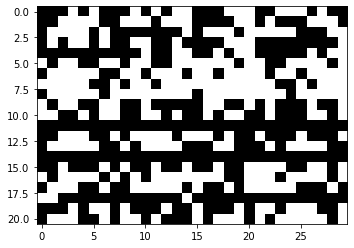

In [66]:
plt.imshow(data[...,3], cmap=plt.get_cmap('binary'))
plt.show()

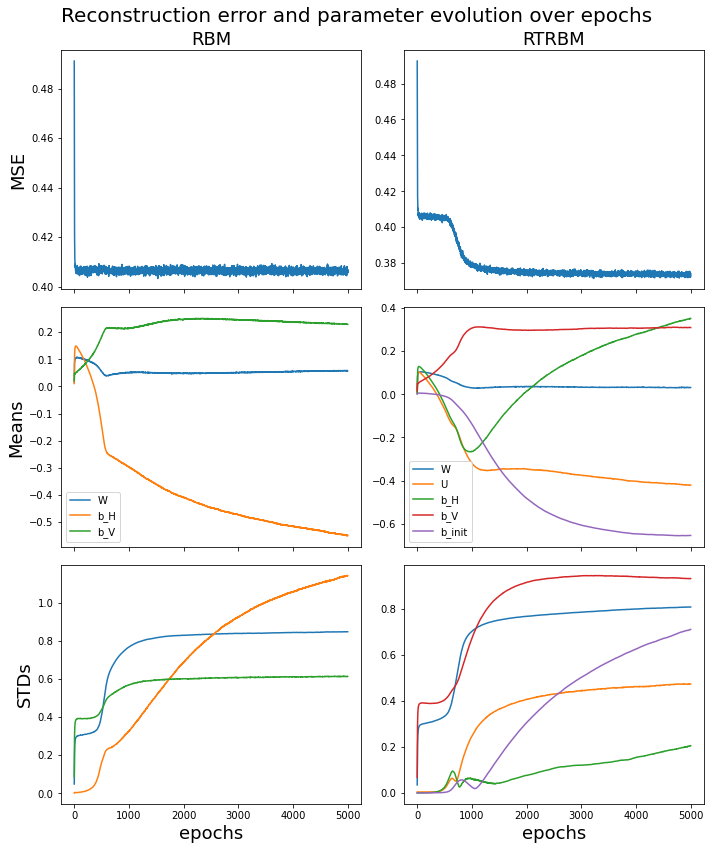

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True)
axes[0, 0].plot(rbm1.errors)
axes[0, 1].plot(rtrbm1.errors)
axes[0, 0].set_title('RBM', fontsize=18)
axes[0, 1].set_title('RTRBM', fontsize=18)
axes[2, 0].set_xlabel('epochs', fontsize=18)
axes[2, 1].set_xlabel('epochs', fontsize=18)
axes[0, 0].set_ylabel('MSE', fontsize=18)
W, U, b_H, b_V, b_init = get_param_history(rtrbm1.parameter_history)
epochs = np.arange(W.shape[0])
params = [W, U, b_H, b_V, b_init]
for param in params:
    axes[1, 1].plot(epochs, torch.mean(param, (1, 2)))
    axes[2, 1].plot(epochs, torch.std(param, (1, 2)))
W, b_H, b_V = get_param_history_rbm(rbm1.parameter_history)
epochs = np.arange(W.shape[0])
params = [W, b_H, b_V]
for param in params:
    axes[1, 0].plot(epochs, torch.mean(param, (1, 2)))
    axes[2, 0].plot(epochs, torch.std(param, (1, 2)))

axes[1, 0].legend(['W', 'b_H', 'b_V'])
axes[1, 1].legend(['W', 'U', 'b_H', 'b_V', 'b_init'])
axes[1, 0].set_ylabel('Means', fontsize=18)
axes[2, 0].set_ylabel('STDs', fontsize=18)

plt.suptitle('Reconstruction error and parameter evolution over epochs', fontsize=20)
plt.tight_layout()
plt.show()

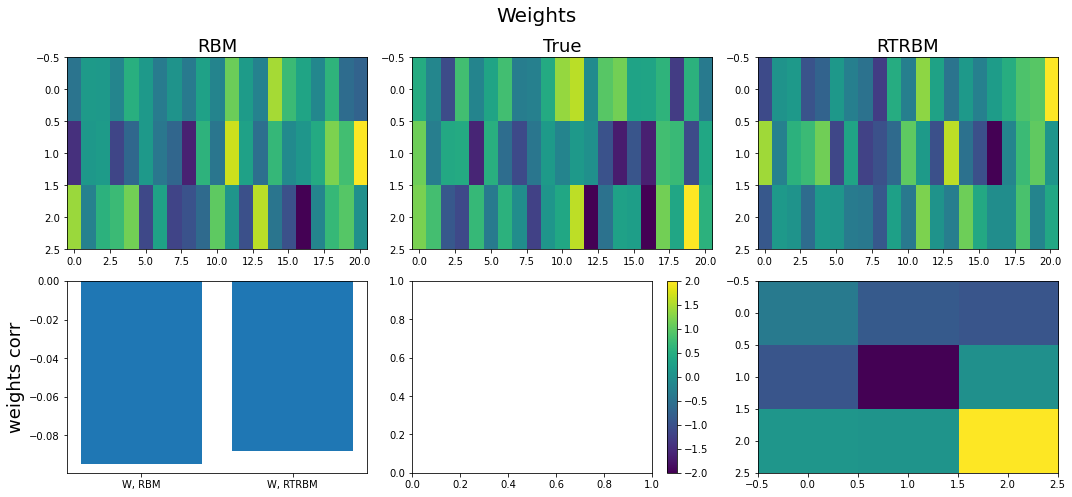

In [72]:
U = rtrbm1.U[(2, 0, 1), :]
U = U[:, (2, 0, 1)]

fig, axes = plt.subplots(2, 3, figsize=(15, 7))

axes[0, 0].imshow(rbm1.W[:, :], aspect='auto', vmin=-2, vmax=2)
axes[0, 1].imshow(generated1.W, aspect='auto', vmin=-2, vmax=2)
cax = axes[0, 2].imshow(rtrbm1.W[:, :], aspect='auto', vmin=-2, vmax=2)
axes[1, 2].imshow(U, aspect='auto')


plt.colorbar(cax, ax=axes[1, 1])

axes[0, 0].set_title('RBM', fontsize=18)
axes[0, 1].set_title('True', fontsize=18)
axes[0, 2].set_title('RTRBM', fontsize=18)

corr_rbm_W1 = np.corrcoef(generated1.W.flatten(), rbm1.W[:, :].flatten())[0, 1]
corr_rtrbm_W1 = np.corrcoef(generated1.W.flatten(), rtrbm1.W[:, :].flatten())[0, 1]
# corr_rtrbm_U = np.corrcoef(generated.U.flatten(), U.flatten())[0, 1]
axes[1, 0].bar(['W, RBM', 'W, RTRBM'], [corr_rbm_W, corr_rtrbm_W])
axes[1, 0].set_ylabel('weights corr', fontsize=18)

fig.suptitle('Weights', fontsize=20)

plt.tight_layout()
plt.show()

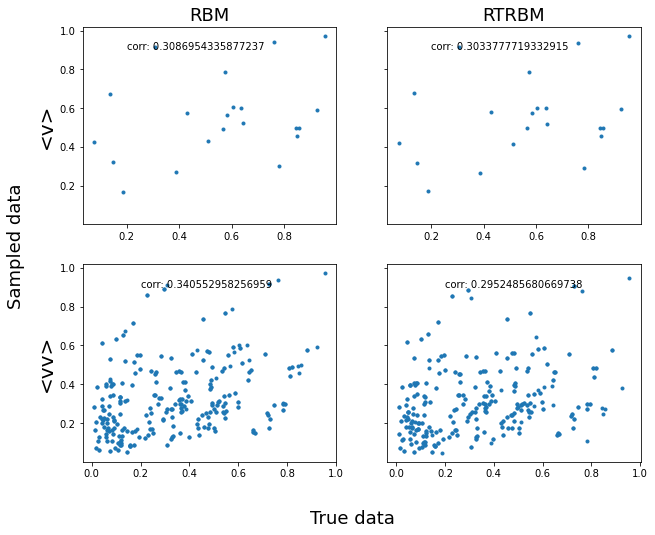

In [60]:
vt1 = reshape_from_batches(data1)
vs_rbm1 = reshape_from_batches(vs_rbm1[:, T//2:, :])
vs_rtrbm1 = reshape_from_batches(vs_rtrbm1[:, T//2:, :])

vvt1 = np.array(torch.matmul(vt1, vt1.T) / vt1.shape[1]).flatten()
vvs_rbm1 = np.array(torch.matmul(vs_rbm1, vs_rbm1.T) / vs_rbm1.shape[1]).flatten()
vvs_rtrbm1 = np.array(torch.matmul(vs_rtrbm1, vs_rtrbm1.T) / vs_rtrbm1.shape[1]).flatten()

vr_rbm1 = np.corrcoef(torch.mean(vt1, 1), torch.mean(vs_rbm1, 1))[0, 1]
vr_rtrbm1 = np.corrcoef(torch.mean(vt1, 1), torch.mean(vs_rtrbm1, 1))[0, 1]
vvr_rbm1 = np.corrcoef(vvt1, vvs_rbm1)[0, 1]
vvr_rtrbm1 = np.corrcoef(vvt1, vvs_rtrbm1)[0, 1]

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

ax[0, 0].plot(torch.mean(vt1, 1), torch.mean(vs_rbm1, 1), '.')
ax[0, 1].plot(torch.mean(vt1, 1), torch.mean(vs_rtrbm1, 1), '.')
ax[0, 0].text(.2, .9, 'corr: ' + str(vr_rbm1))
ax[0, 1].text(.2, .9, 'corr: ' + str(vr_rtrbm1))

ax[1, 0].plot(vvt1, vvs_rbm1, '.')
ax[1, 1].plot(vvt1, vvs_rtrbm1, '.')
ax[1, 0].text(.2, .9, 'corr: ' + str(vvr_rbm1))
ax[1, 1].text(.2, .9, 'corr: ' + str(vvr_rtrbm1))

ax[0, 0].set_title('RBM', fontsize=18)
ax[0, 0].set_ylabel('<v>', fontsize=20)
ax[1, 0].set_ylabel('<vv>', fontsize=20)
ax[0, 1].set_title('RTRBM', fontsize=18)

fig.supylabel('Sampled data', fontsize=18)
fig.supxlabel('True data', fontsize=18)
plt.show()